# GAN Project, Working through CycleGans
Prepared by Ryan Birmingham
Data from https://www.kaggle.com/competitions/gan-getting-started/overview/description

# About The project, and Cycle Gan
This is a follow up to part 1.
We have a large number of photos, and a smaller number of monet works. We're trying to generate a large number of monet styled works. Since a simple gan did not work very well here, let's try a cycle gan per the project suggestion.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# kaggle input files, autopopulated
! ls /kaggle/input/gan-getting-started/

monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


In [2]:
! ls /kaggle/input/gan-getting-started/monet_jpg | head

000c1e3bff.jpg
011835cfbf.jpg
0260d15306.jpg
049e293b93.jpg
05144e306f.jpg
052a77c020.jpg
058f878b7c.jpg
05b493ff42.jpg
064487d630.jpg
066fe4cbaa.jpg


In [3]:
ls -l /kaggle/input/gan-getting-started/monet_jpg | wc -l

301


In [4]:
! ls /kaggle/input/gan-getting-started/photo_jpg | head

00068bc07f.jpg
000910d219.jpg
000ded5c41.jpg
00104fd531.jpg
001158d595.jpg
0033c5f971.jpg
0039ebb598.jpg
003aab6fdd.jpg
003c6c30e0.jpg
00479e2a21.jpg
ls: write error: Broken pipe


In [5]:
ls -l /kaggle/input/gan-getting-started/photo_jpg | wc -l

7039


In [6]:
import os
from PIL import Image


monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'

monet_sizes = []
photo_sizes = []

for filename in os.scandir(monet_dir):
    if filename.is_file():
        with Image.open(filename.path) as img:
            monet_sizes.append(img.size)
            
for filename in os.scandir(photo_dir):
    if filename.is_file():
        with Image.open(filename.path) as img:
            photo_sizes.append(img.size)

showing /kaggle/input/gan-getting-started/monet_jpg/2acfbab228.jpg


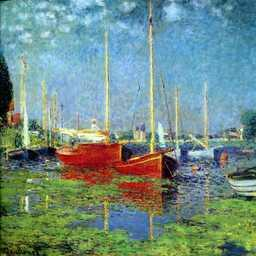

showing /kaggle/input/gan-getting-started/monet_jpg/32cc820303.jpg


showing /kaggle/input/gan-getting-started/monet_jpg/a030bc32e6.jpg


showing /kaggle/input/gan-getting-started/monet_jpg/732d76a469.jpg


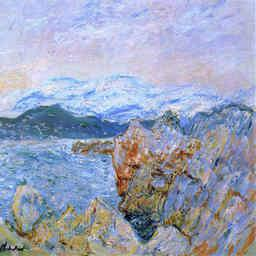

In [7]:
import random
from IPython.display import Image

for filename in os.scandir(monet_dir):
    if filename.is_file():
        if random.random() > 0.98:
            print("showing", filename.path)
            display(Image(filename=filename.path))

showing /kaggle/input/gan-getting-started/photo_jpg/4b497dc591.jpg


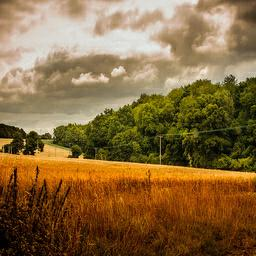

showing /kaggle/input/gan-getting-started/photo_jpg/f4eb47f0dd.jpg


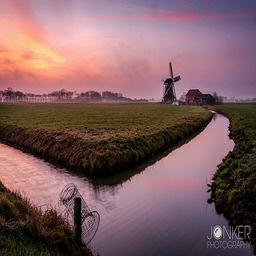

showing /kaggle/input/gan-getting-started/photo_jpg/dcfa634264.jpg


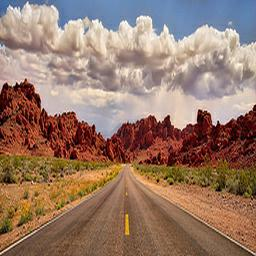

showing /kaggle/input/gan-getting-started/photo_jpg/816320a79c.jpg


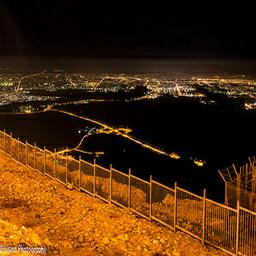

showing /kaggle/input/gan-getting-started/photo_jpg/cd9d87bc3d.jpg


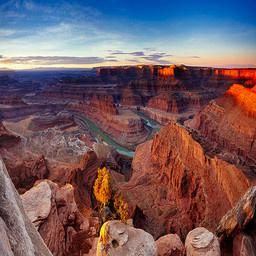

showing /kaggle/input/gan-getting-started/photo_jpg/3778fecb0c.jpg


showing /kaggle/input/gan-getting-started/photo_jpg/8c3f71bb3d.jpg


showing /kaggle/input/gan-getting-started/photo_jpg/5edefd0d0f.jpg


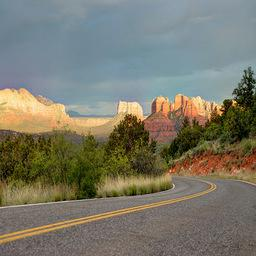

In [8]:
for filename in os.scandir(photo_dir):
    if filename.is_file():
        if random.random() > 0.999:
            print("showing", filename.path)
            display(Image(filename=filename.path))

# Data as Inputs
We know the images are 256x256, and jpg. Let's make a keras dataset out of them.

In [9]:
import tensorflow as tf
monet_data = tf.keras.utils.image_dataset_from_directory(monet_dir, label_mode=None, image_size=(256, 256), batch_size=32)
photo_data = tf.keras.utils.image_dataset_from_directory(photo_dir, label_mode=None, image_size=(256, 256), batch_size=32)
# normalize and resize
monet_data = monet_data.map(lambda x: x / 255.0)
monet_data = monet_data.map(lambda img: tf.keras.preprocessing.image.smart_resize(img, (64,64)))

photo_data = photo_data.map(lambda x: x / 255.0)
photo_data = photo_data.map(lambda img: tf.keras.preprocessing.image.smart_resize(img, (64,64)))

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

## Image normalization
Normalize the pixel values, and crop/pad any images which are somehow not the right size after conversion.

In [11]:
# adapted from the keras docs, https://keras.io/examples/generative/cyclegan/


# Define the standard image size.
orig_img_size = (64, 64)
# Size of the random crops to be used during training.
input_img_size = (64, 64, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, [*orig_img_size])
    img = tf.image.random_crop(img, size=[*input_img_size])
    img = normalize_img(img)
    return img


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

## The Generator
The generator needs to have layers such that it can reach our image size. Each layer needs padding, convolution, normalization, and activation. Then to call the normalization steps.

In [12]:
# adapted from keras cycle gan docs at https://keras.io/examples/generative/cyclegan/
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

# The Discriminator
The Discriminiator needs to take in an image and determine if it's from the real or synthetic dataset. So it needs to classify from a 64x64 image to a single classification.

In [13]:
# adapted from keras cycle gan docs at https://keras.io/examples/generative/cyclegan/
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [14]:
# adapted from keras cycle gan docs at https://keras.io/examples/generative/cyclegan/
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [15]:
# adapted from keras docs at https://keras.io/examples/generative/cyclegan/
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_data.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

Epoch 1/30
10/10 [==============================] - ETA: 0s - G_loss: 6.5221 - F_loss: 8.4006 - D_X_loss: 0.4680 - D_Y_loss: 0.4661 

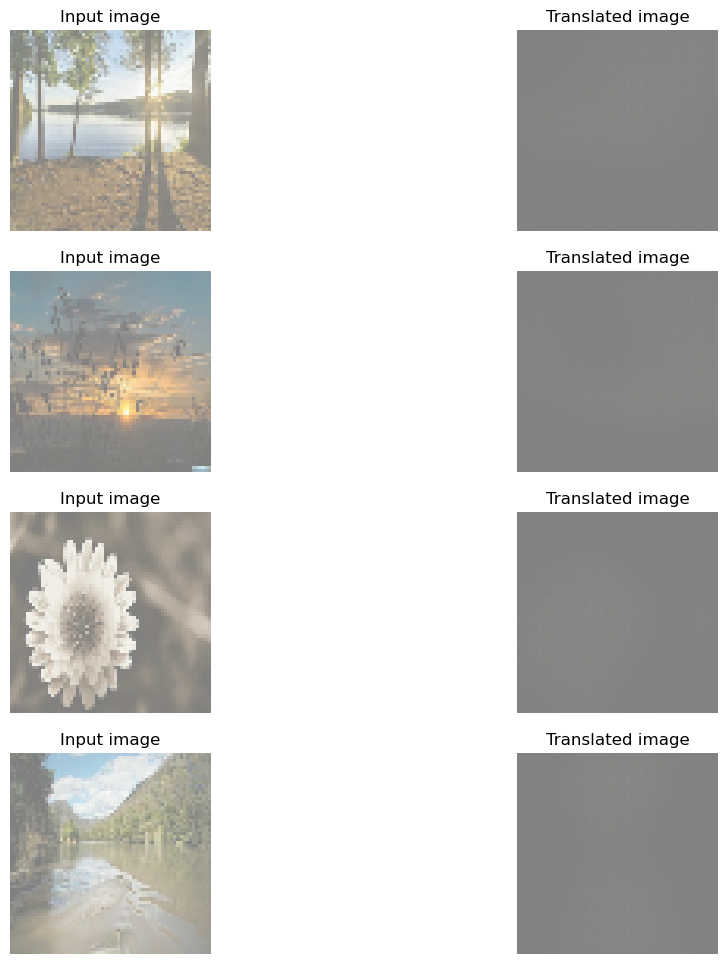

10/10 [==============================] - 547s 47s/step - G_loss: 6.5091 - F_loss: 8.3670 - D_X_loss: 0.4630 - D_Y_loss: 0.4606
Epoch 2/30
10/10 [==============================] - ETA: 0s - G_loss: 5.3986 - F_loss: 7.2019 - D_X_loss: 0.3308 - D_Y_loss: 0.3337 

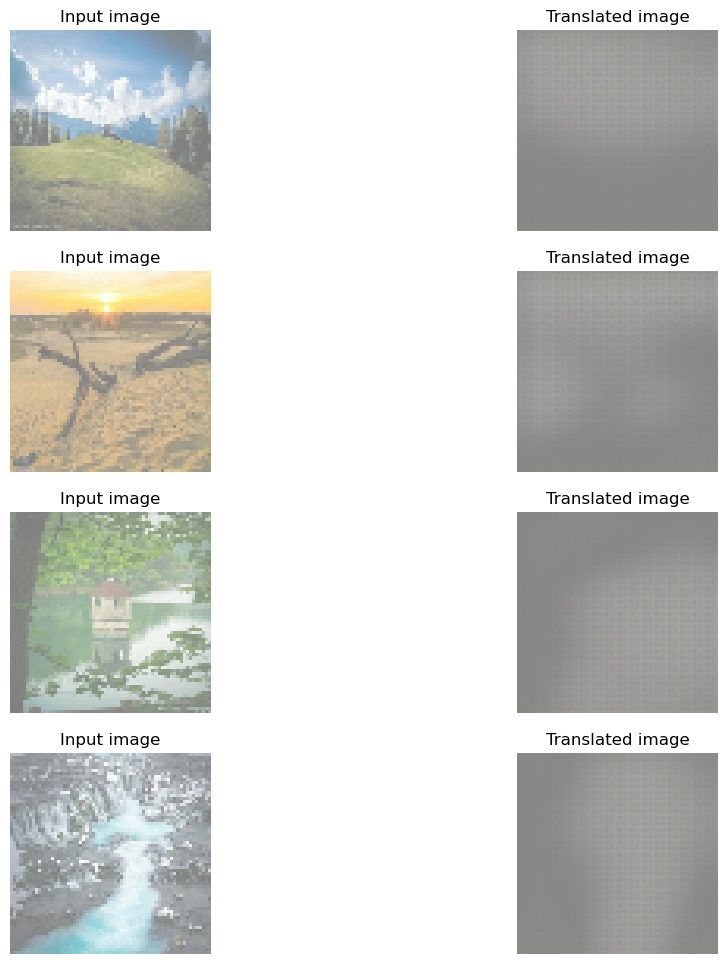

10/10 [==============================] - 466s 46s/step - G_loss: 5.2763 - F_loss: 7.1140 - D_X_loss: 0.3269 - D_Y_loss: 0.3305
Epoch 3/30
10/10 [==============================] - ETA: 0s - G_loss: 3.7938 - F_loss: 4.9699 - D_X_loss: 0.2507 - D_Y_loss: 0.2624 

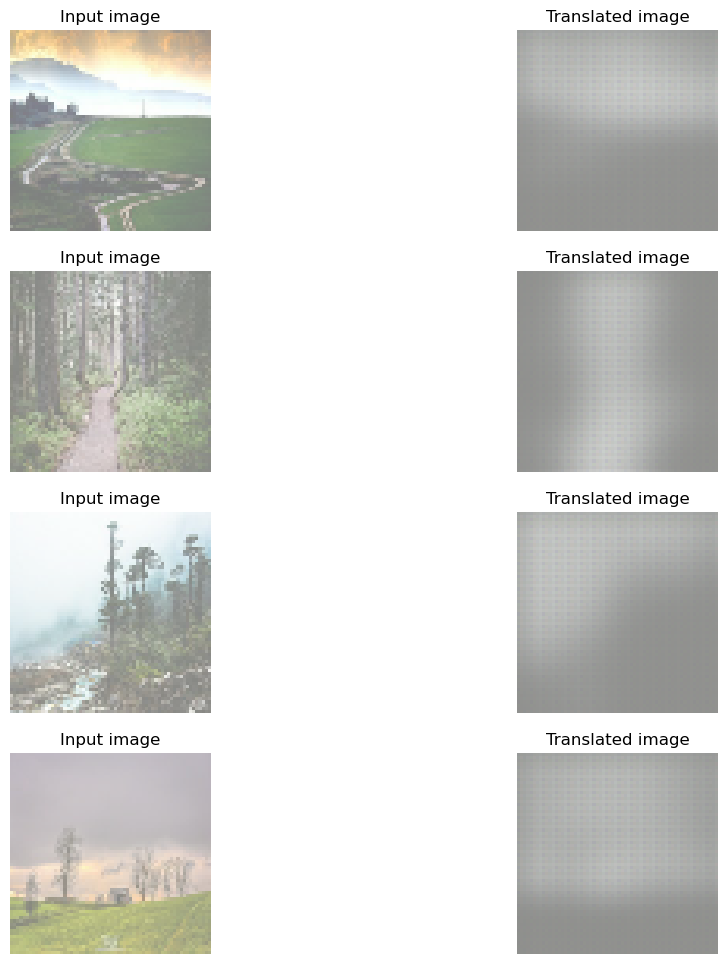

10/10 [==============================] - 467s 47s/step - G_loss: 3.7546 - F_loss: 4.8409 - D_X_loss: 0.2489 - D_Y_loss: 0.2594
Epoch 4/30
10/10 [==============================] - ETA: 0s - G_loss: 3.1221 - F_loss: 3.1811 - D_X_loss: 0.2156 - D_Y_loss: 0.2092 

10/10 [==============================] - 466s 46s/step - G_loss: 3.0973 - F_loss: 3.1493 - D_X_loss: 0.2159 - D_Y_loss: 0.2057
Epoch 5/30
10/10 [==============================] - ETA: 0s - G_loss: 2.9082 - F_loss: 2.6448 - D_X_loss: 0.1742 - D_Y_loss: 0.1563 

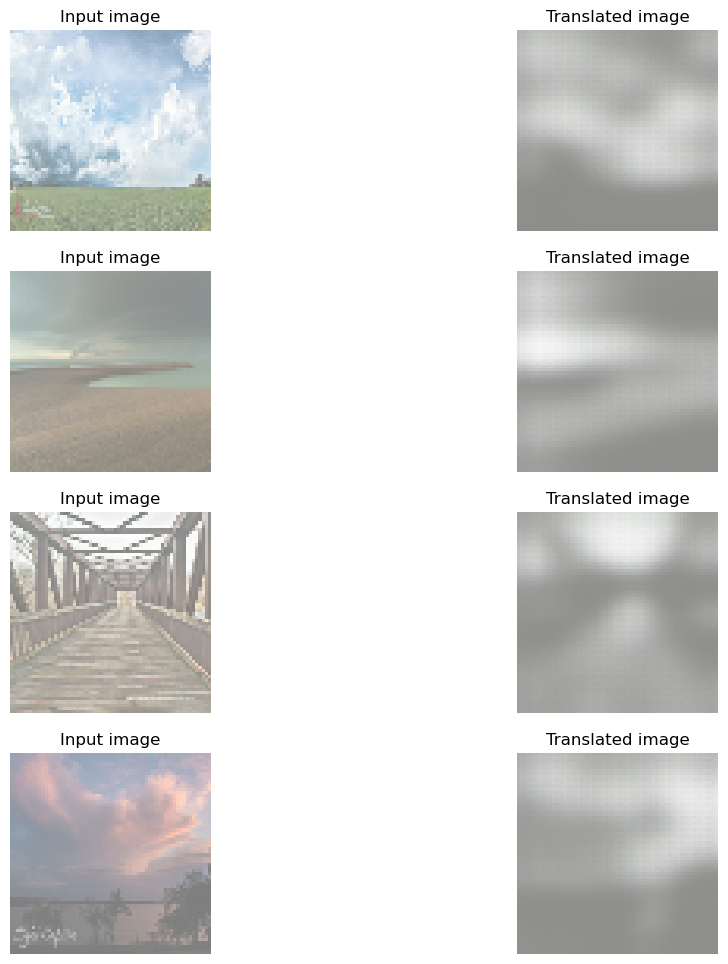

10/10 [==============================] - 478s 48s/step - G_loss: 2.8975 - F_loss: 2.6249 - D_X_loss: 0.1695 - D_Y_loss: 0.1551
Epoch 6/30
10/10 [==============================] - ETA: 0s - G_loss: 2.9697 - F_loss: 2.6413 - D_X_loss: 0.1376 - D_Y_loss: 0.1119 

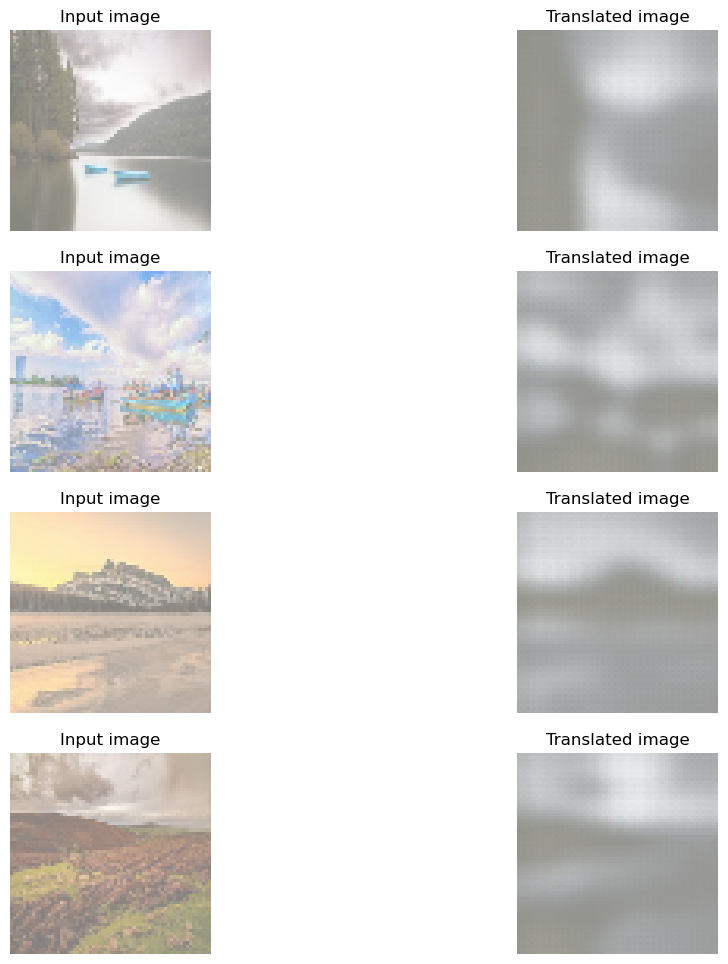

10/10 [==============================] - 469s 47s/step - G_loss: 2.9638 - F_loss: 2.6677 - D_X_loss: 0.1328 - D_Y_loss: 0.1137
Epoch 7/30
10/10 [==============================] - ETA: 0s - G_loss: 2.8401 - F_loss: 2.7066 - D_X_loss: 0.0832 - D_Y_loss: 0.1996 

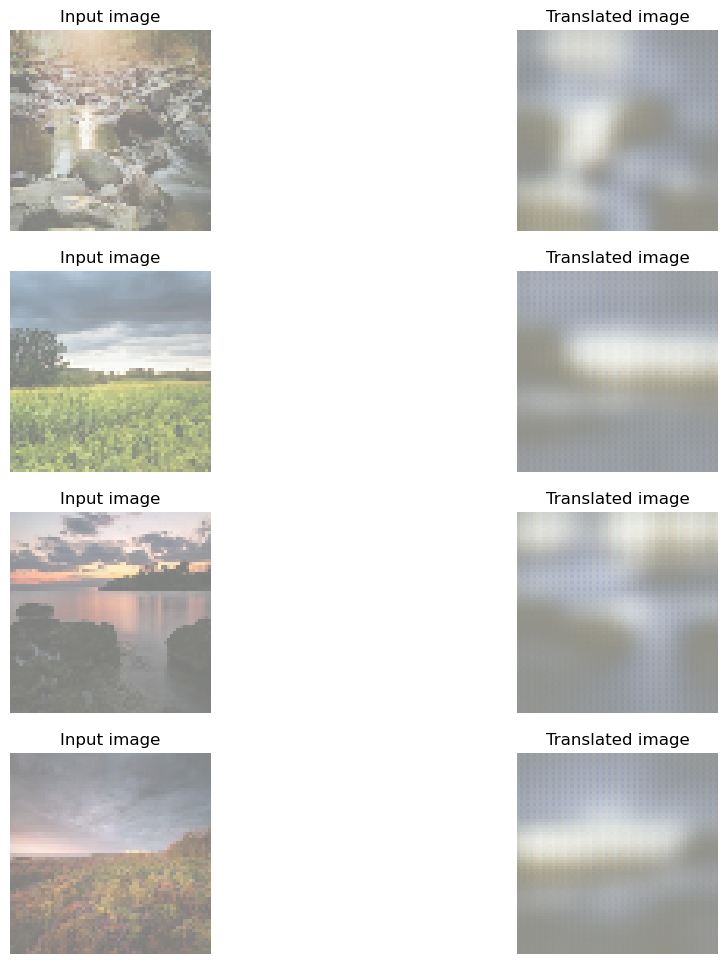

10/10 [==============================] - 474s 47s/step - G_loss: 2.8180 - F_loss: 2.7035 - D_X_loss: 0.0830 - D_Y_loss: 0.2041
Epoch 8/30
10/10 [==============================] - ETA: 0s - G_loss: 2.8418 - F_loss: 2.6040 - D_X_loss: 0.1470 - D_Y_loss: 0.2224 

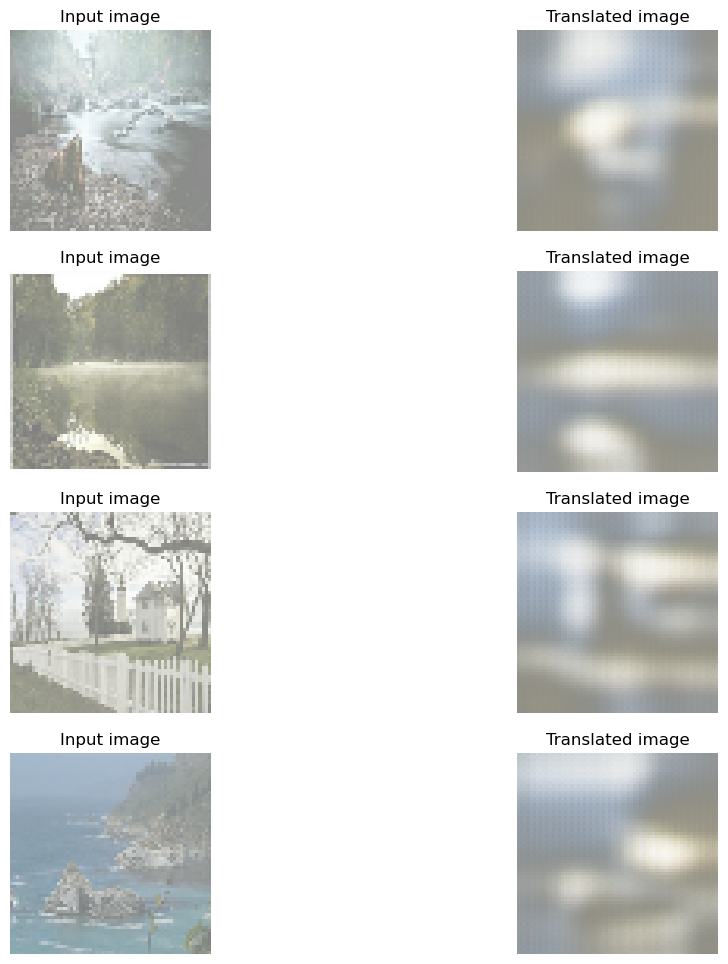

10/10 [==============================] - 468s 47s/step - G_loss: 2.8450 - F_loss: 2.5952 - D_X_loss: 0.1556 - D_Y_loss: 0.2217
Epoch 9/30
10/10 [==============================] - ETA: 0s - G_loss: 2.8076 - F_loss: 2.5807 - D_X_loss: 0.2066 - D_Y_loss: 0.2171 

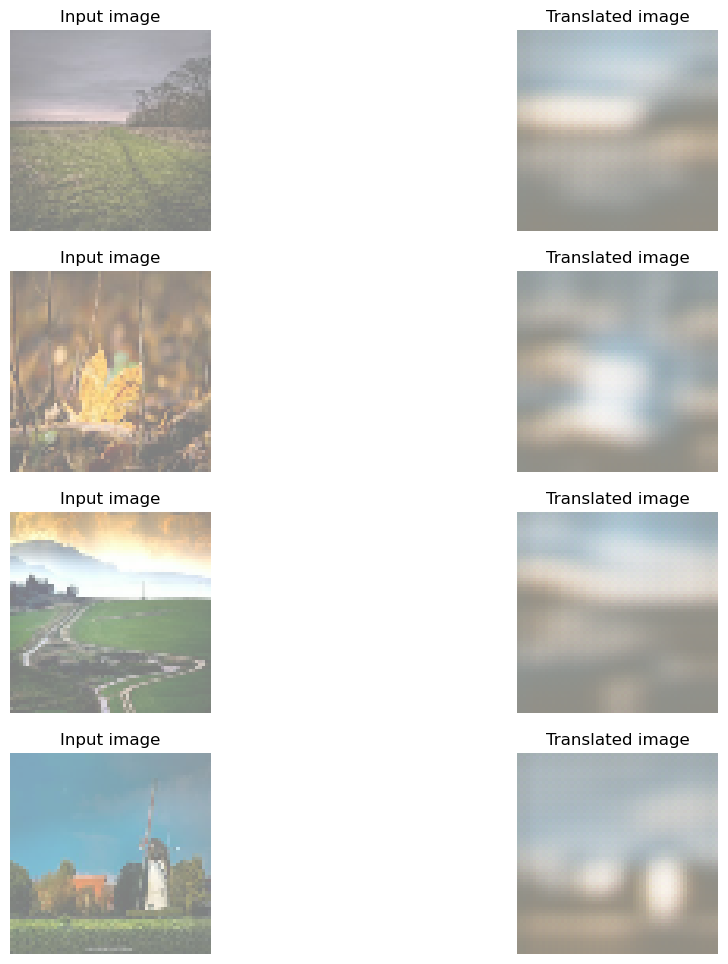

10/10 [==============================] - 468s 47s/step - G_loss: 2.7968 - F_loss: 2.5530 - D_X_loss: 0.2041 - D_Y_loss: 0.2199
Epoch 10/30
10/10 [==============================] - ETA: 0s - G_loss: 2.8094 - F_loss: 2.5575 - D_X_loss: 0.1963 - D_Y_loss: 0.2230 

10/10 [==============================] - 468s 47s/step - G_loss: 2.8330 - F_loss: 2.5749 - D_X_loss: 0.1938 - D_Y_loss: 0.2191
Epoch 11/30
10/10 [==============================] - ETA: 0s - G_loss: 2.7807 - F_loss: 2.5688 - D_X_loss: 0.2106 - D_Y_loss: 0.1993 

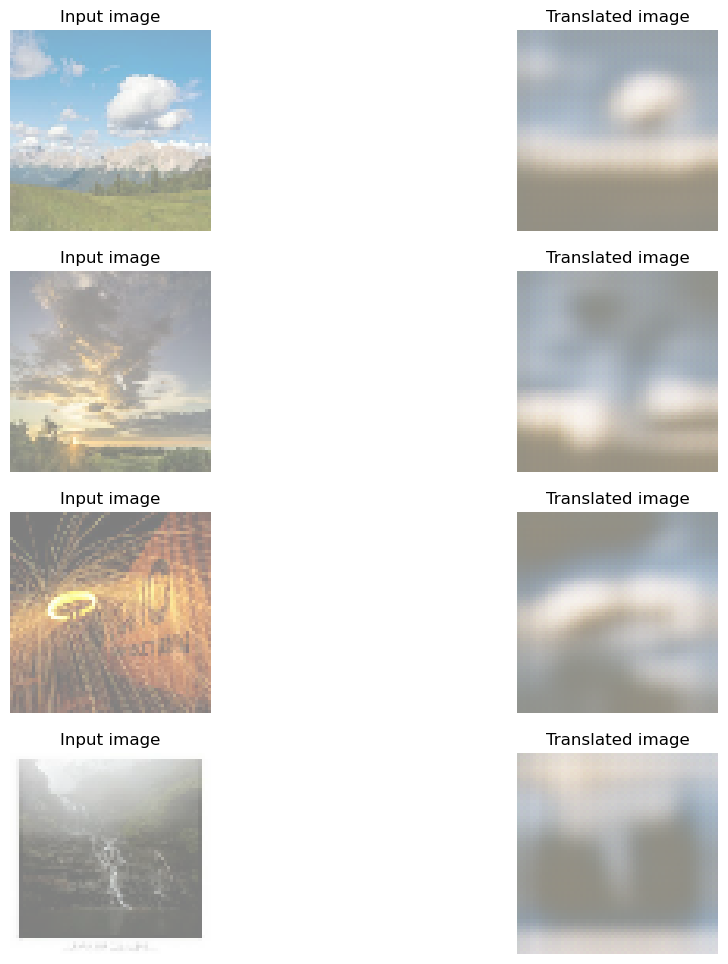

10/10 [==============================] - 463s 46s/step - G_loss: 2.7775 - F_loss: 2.5722 - D_X_loss: 0.2096 - D_Y_loss: 0.2034
Epoch 12/30
10/10 [==============================] - ETA: 0s - G_loss: 2.7745 - F_loss: 2.5087 - D_X_loss: 0.1831 - D_Y_loss: 0.1520 

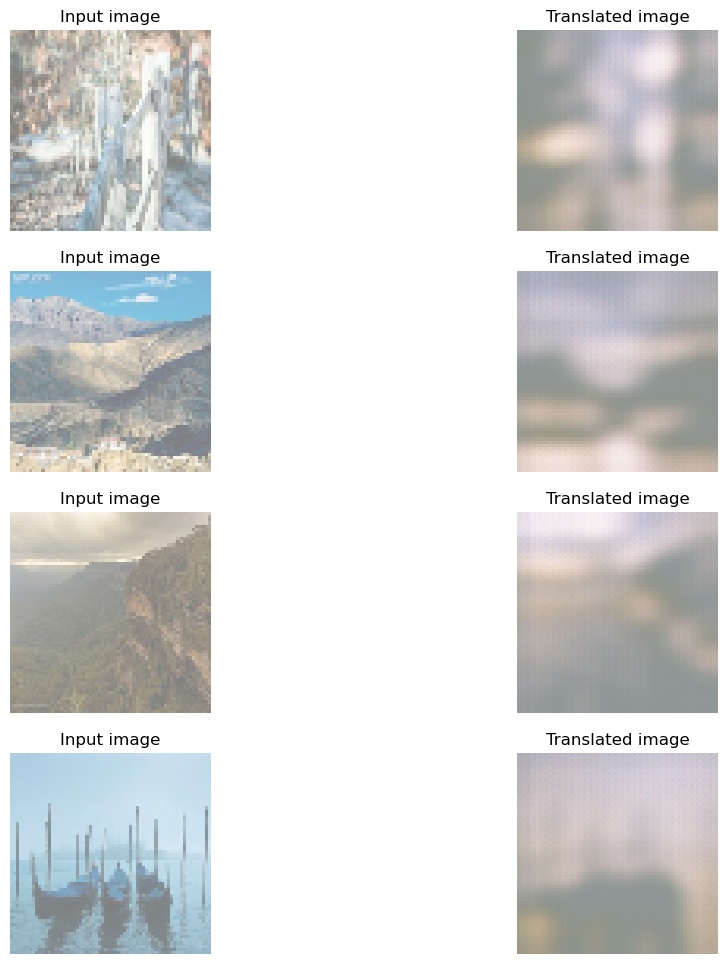

10/10 [==============================] - 477s 48s/step - G_loss: 2.7607 - F_loss: 2.5035 - D_X_loss: 0.1805 - D_Y_loss: 0.1534
Epoch 13/30
10/10 [==============================] - ETA: 0s - G_loss: 2.8141 - F_loss: 2.4859 - D_X_loss: 0.2043 - D_Y_loss: 0.1863 

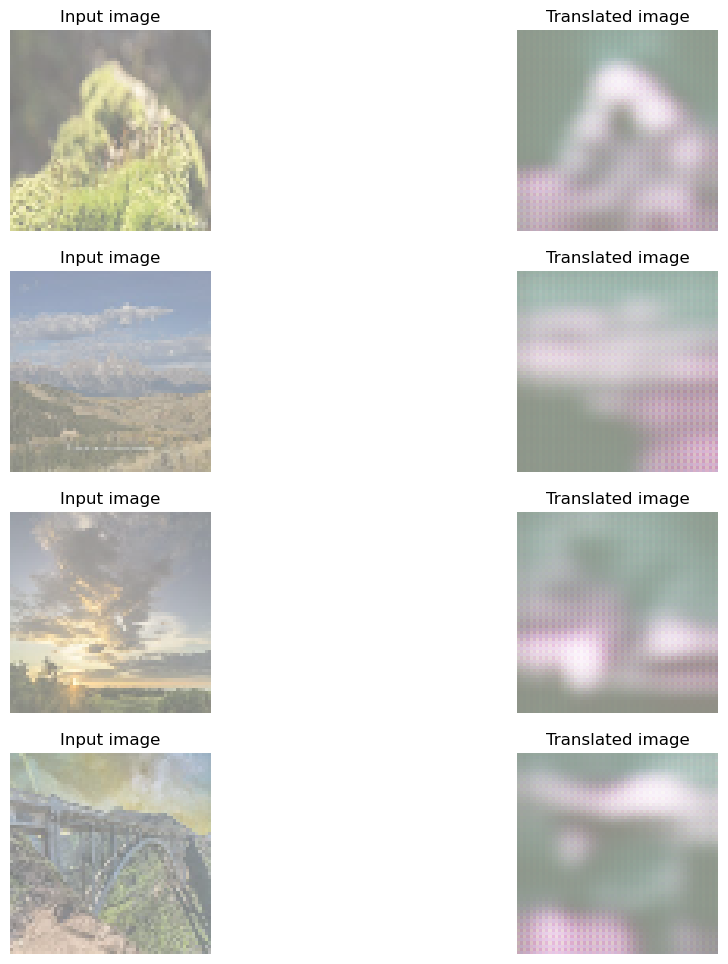

10/10 [==============================] - 468s 47s/step - G_loss: 2.8143 - F_loss: 2.4749 - D_X_loss: 0.2086 - D_Y_loss: 0.1820
Epoch 14/30
10/10 [==============================] - ETA: 0s - G_loss: 2.7563 - F_loss: 2.4919 - D_X_loss: 0.2467 - D_Y_loss: 0.2135 

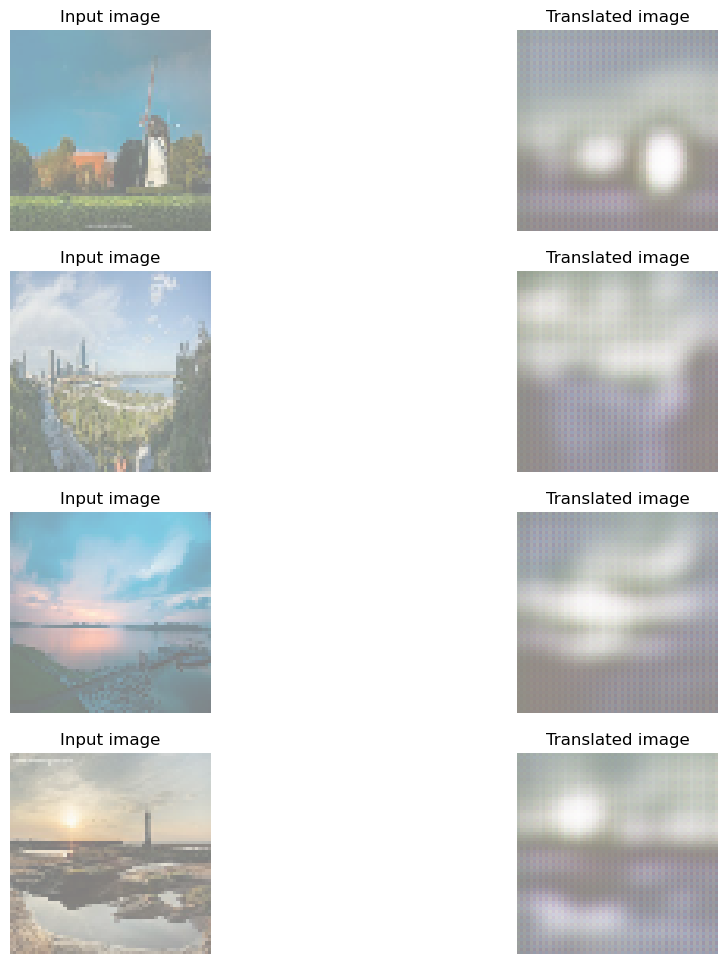

10/10 [==============================] - 478s 47s/step - G_loss: 2.7714 - F_loss: 2.4943 - D_X_loss: 0.2452 - D_Y_loss: 0.2157
Epoch 15/30
10/10 [==============================] - ETA: 0s - G_loss: 2.7770 - F_loss: 2.4568 - D_X_loss: 0.2376 - D_Y_loss: 0.2071 

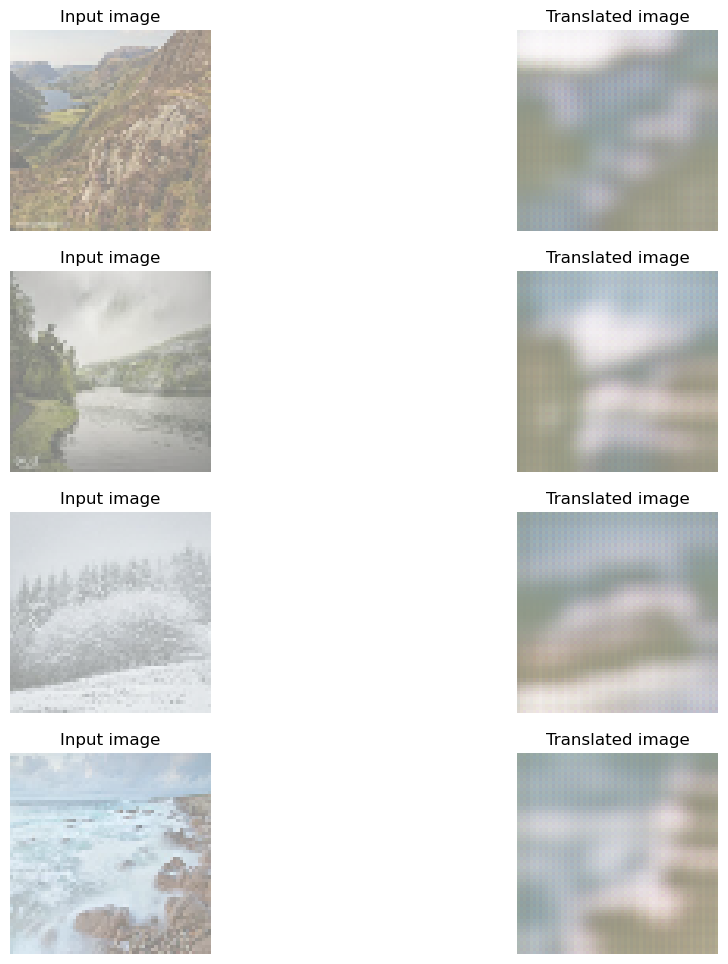

10/10 [==============================] - 469s 47s/step - G_loss: 2.7685 - F_loss: 2.4399 - D_X_loss: 0.2360 - D_Y_loss: 0.2127
Epoch 16/30
10/10 [==============================] - ETA: 0s - G_loss: 2.6591 - F_loss: 2.4617 - D_X_loss: 0.2137 - D_Y_loss: 0.2488 

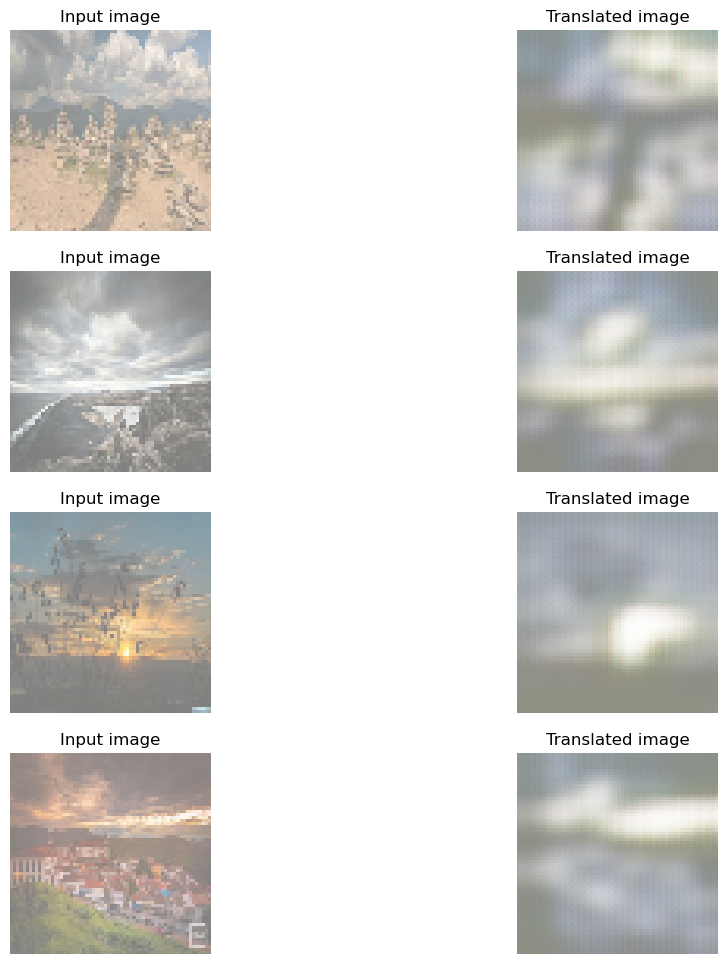

10/10 [==============================] - 469s 47s/step - G_loss: 2.6276 - F_loss: 2.4511 - D_X_loss: 0.2128 - D_Y_loss: 0.2473
Epoch 17/30
10/10 [==============================] - ETA: 0s - G_loss: 2.6340 - F_loss: 2.4492 - D_X_loss: 0.1926 - D_Y_loss: 0.2493 

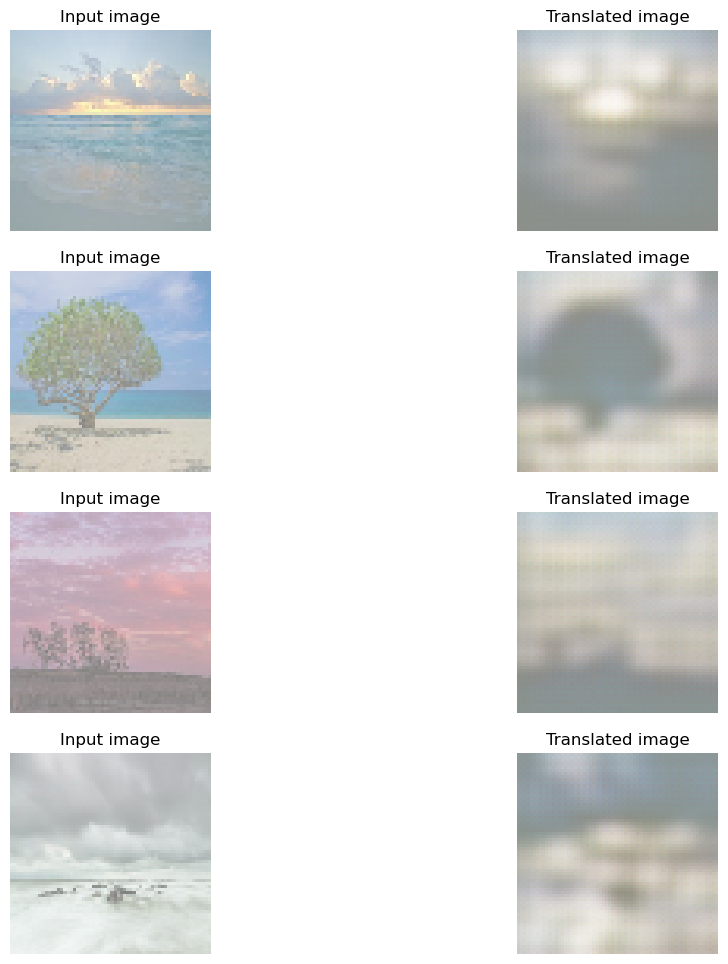

10/10 [==============================] - 471s 47s/step - G_loss: 2.6522 - F_loss: 2.4622 - D_X_loss: 0.1894 - D_Y_loss: 0.2493
Epoch 18/30
10/10 [==============================] - ETA: 0s - G_loss: 2.5447 - F_loss: 2.4531 - D_X_loss: 0.1799 - D_Y_loss: 0.2357 

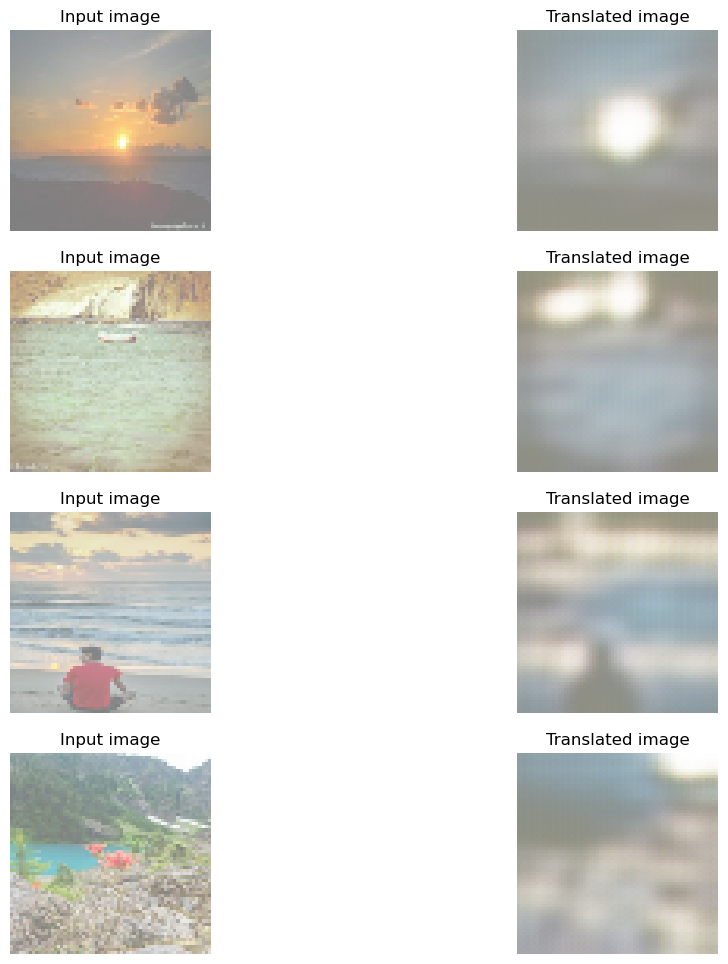

10/10 [==============================] - 466s 46s/step - G_loss: 2.5579 - F_loss: 2.4484 - D_X_loss: 0.1813 - D_Y_loss: 0.2355
Epoch 19/30
10/10 [==============================] - ETA: 0s - G_loss: 2.5865 - F_loss: 2.4506 - D_X_loss: 0.1649 - D_Y_loss: 0.2335 

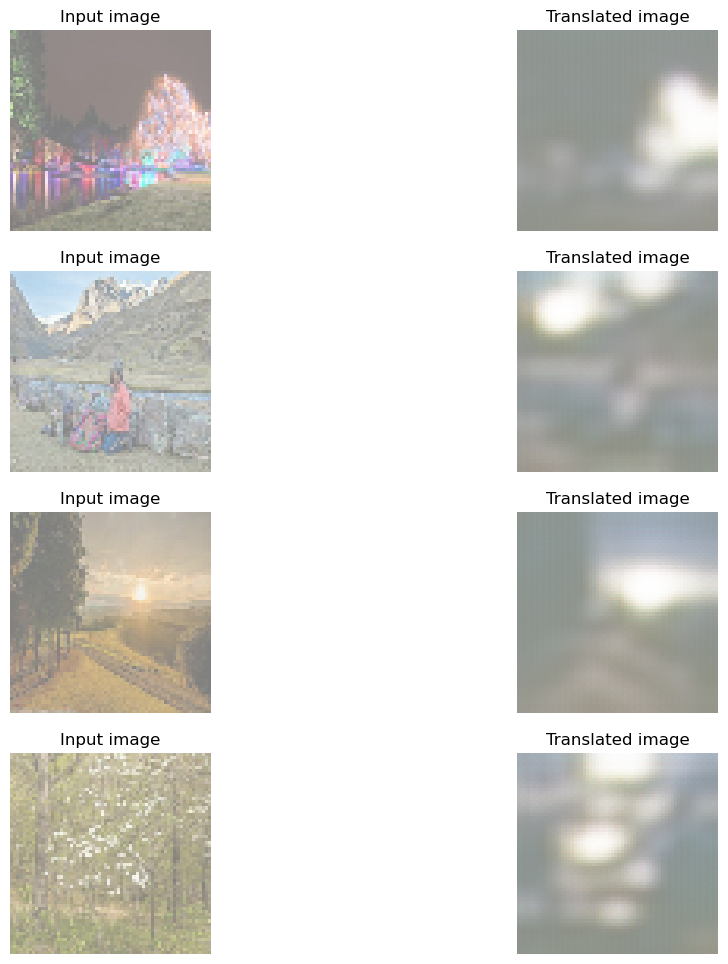

10/10 [==============================] - 480s 48s/step - G_loss: 2.5940 - F_loss: 2.4403 - D_X_loss: 0.1676 - D_Y_loss: 0.2334
Epoch 20/30
10/10 [==============================] - ETA: 0s - G_loss: 2.6030 - F_loss: 2.4854 - D_X_loss: 0.1574 - D_Y_loss: 0.2201 

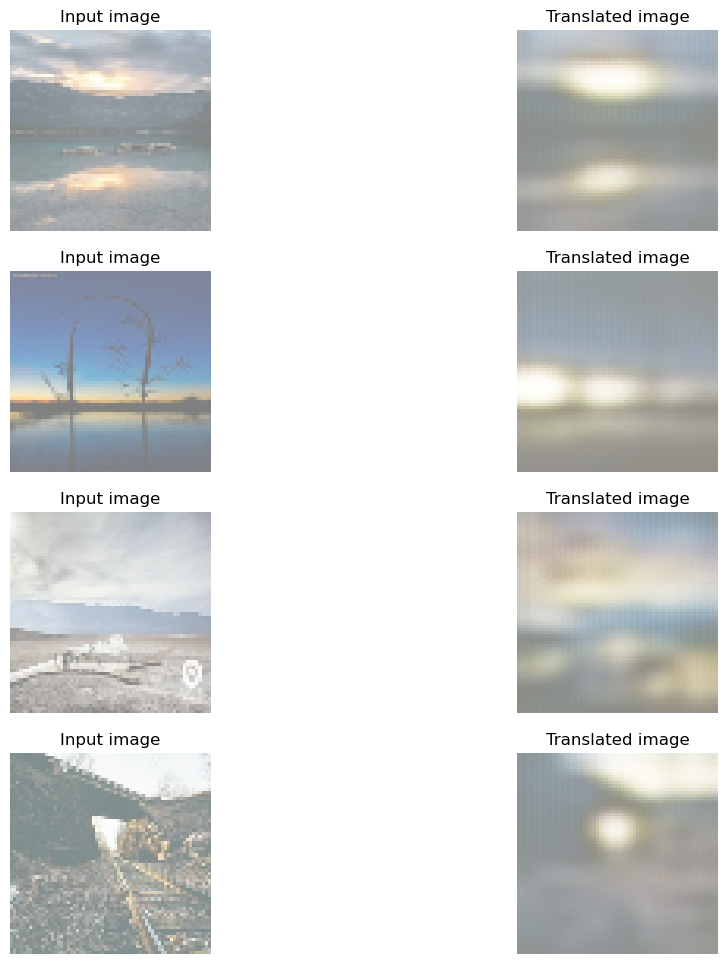

10/10 [==============================] - 470s 47s/step - G_loss: 2.5729 - F_loss: 2.5061 - D_X_loss: 0.1606 - D_Y_loss: 0.2213
Epoch 21/30
10/10 [==============================] - ETA: 0s - G_loss: 2.5141 - F_loss: 2.4681 - D_X_loss: 0.1640 - D_Y_loss: 0.2076 

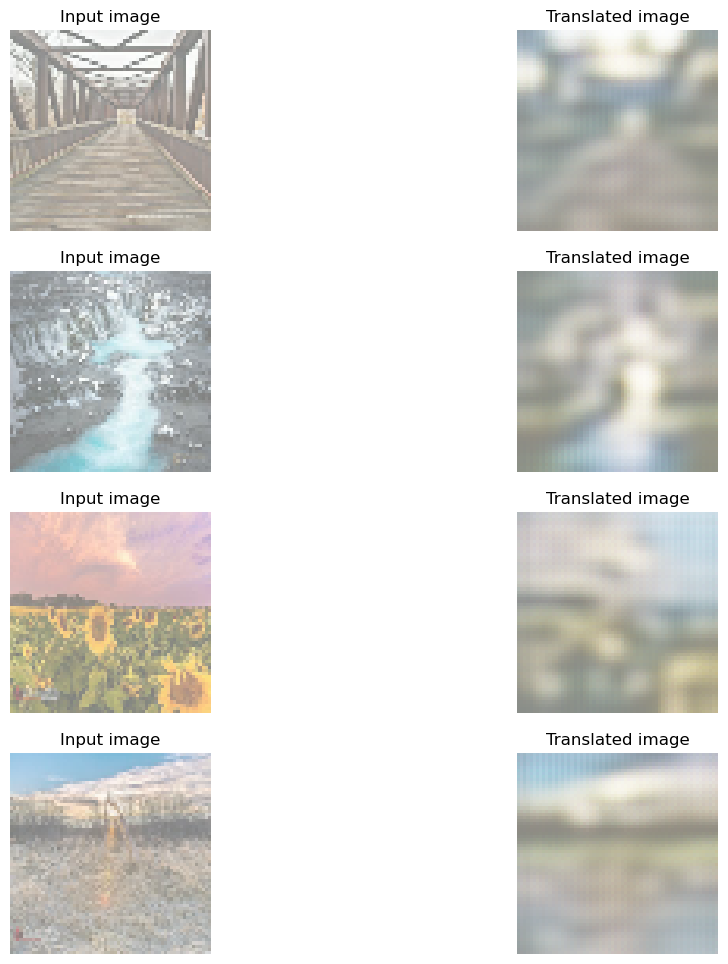

10/10 [==============================] - 477s 47s/step - G_loss: 2.5254 - F_loss: 2.4653 - D_X_loss: 0.1612 - D_Y_loss: 0.2052
Epoch 22/30
10/10 [==============================] - ETA: 0s - G_loss: 2.6324 - F_loss: 2.5462 - D_X_loss: 0.1605 - D_Y_loss: 0.2049 

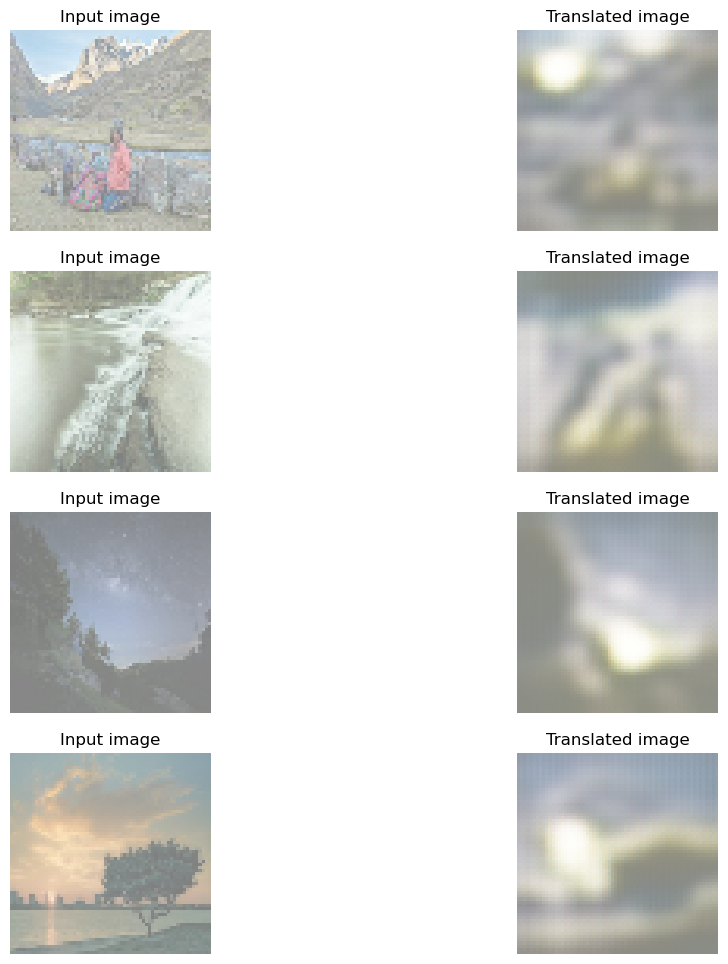

10/10 [==============================] - 468s 47s/step - G_loss: 2.6166 - F_loss: 2.5434 - D_X_loss: 0.1639 - D_Y_loss: 0.2051
Epoch 23/30
10/10 [==============================] - ETA: 0s - G_loss: 2.4954 - F_loss: 2.4864 - D_X_loss: 0.1403 - D_Y_loss: 0.2088 

10/10 [==============================] - 467s 47s/step - G_loss: 2.4988 - F_loss: 2.4752 - D_X_loss: 0.1387 - D_Y_loss: 0.2073
Epoch 24/30
10/10 [==============================] - ETA: 0s - G_loss: 2.6358 - F_loss: 2.5230 - D_X_loss: 0.1799 - D_Y_loss: 0.2061 

10/10 [==============================] - 474s 47s/step - G_loss: 2.6441 - F_loss: 2.5104 - D_X_loss: 0.1794 - D_Y_loss: 0.2073
Epoch 25/30
10/10 [==============================] - ETA: 0s - G_loss: 2.6028 - F_loss: 2.6120 - D_X_loss: 0.1692 - D_Y_loss: 0.2147 

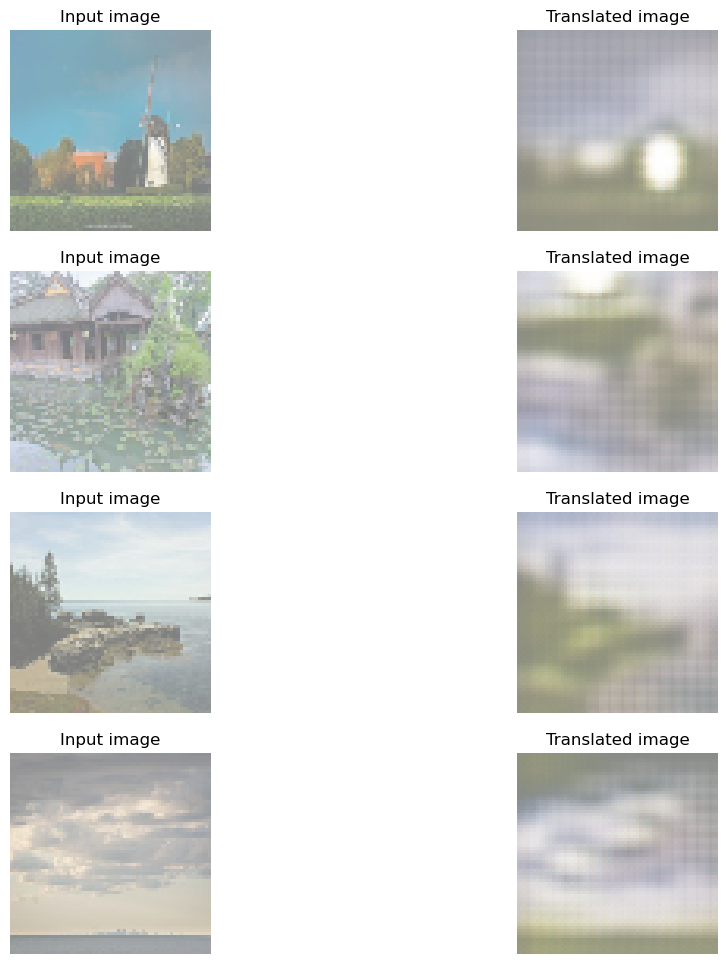

10/10 [==============================] - 466s 46s/step - G_loss: 2.5796 - F_loss: 2.6128 - D_X_loss: 0.1756 - D_Y_loss: 0.2155
Epoch 26/30
10/10 [==============================] - ETA: 0s - G_loss: 2.5572 - F_loss: 2.5490 - D_X_loss: 0.1849 - D_Y_loss: 0.2289 

10/10 [==============================] - 497s 50s/step - G_loss: 2.5731 - F_loss: 2.5479 - D_X_loss: 0.1857 - D_Y_loss: 0.2317
Epoch 27/30
10/10 [==============================] - ETA: 0s - G_loss: 2.5466 - F_loss: 2.5533 - D_X_loss: 0.1765 - D_Y_loss: 0.2269 

10/10 [==============================] - 473s 47s/step - G_loss: 2.5313 - F_loss: 2.5260 - D_X_loss: 0.1755 - D_Y_loss: 0.2231
Epoch 28/30
10/10 [==============================] - ETA: 0s - G_loss: 2.5398 - F_loss: 2.5804 - D_X_loss: 0.2018 - D_Y_loss: 0.1956 

10/10 [==============================] - 470s 47s/step - G_loss: 2.5233 - F_loss: 2.6329 - D_X_loss: 0.1988 - D_Y_loss: 0.1957
Epoch 29/30
10/10 [==============================] - ETA: 0s - G_loss: 2.5676 - F_loss: 2.5031 - D_X_loss: 0.1590 - D_Y_loss: 0.1834 

10/10 [==============================] - 480s 47s/step - G_loss: 2.5647 - F_loss: 2.5043 - D_X_loss: 0.1547 - D_Y_loss: 0.1825
Epoch 30/30
10/10 [==============================] - ETA: 0s - G_loss: 2.6378 - F_loss: 2.5682 - D_X_loss: 0.1730 - D_Y_loss: 0.1745 

10/10 [==============================] - 468s 47s/step - G_loss: 2.6321 - F_loss: 2.5439 - D_X_loss: 0.1759 - D_Y_loss: 0.1801


In [16]:
# adapted from keras docs at https://keras.io/examples/generative/cyclegan/

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_data, photo_data)),
    epochs=30,
    callbacks=[plotter, model_checkpoint_callback],
)

In [17]:
G_losses = [4.9438,3.8508,3.0935,3.0074,2.9611,2.9250,2.7813,2.7978,2.7021,2.7609]
F_losses = [6.3651,4.8256,3.3651,2.7573,2.6061,2.6654,2.6387,2.6007,2.5513,2.5784]
DX_losses = [0.2594,0.2086,0.1787,0.1617,0.1507,0.0944,0.1358,0.2084,0.1979,0.1935]
DY_losses = [0.2642,0.2062,0.1710,0.1310,0.1026,0.0864,0.1565,0.2402,0.2189,0.2096]
plt.plot(G_losses)
plt.plot(F_losses)
plt.plot(DX_losses)
plt.plot(DY_losses)

## Analysis
(un)fortunately, our discriminator is doing much better than our generator on loss (altough this is difficult to compare as they're different metrics and tasks). We do see clear improvement in the generators with epochs, but still no uptick in discriminator. This implies that it may be a lot more training before this becomes complete.

## Discussion and Conclusion
This process has a lot of hyperparameters, and the dataset had relatively few monet images. Nonetheless, we're starting to see some similarities at 10 epochs. However, 10 is clearly not enough, but these take a long time to run. We do see clear improvements from epoch 1 to 10 though, so this is likely okay enough for this minor exploration. It may be interesting to revisit.
## Submission
Prepare some images for submission.

In [21]:
! mkdir output
# generating outputs
def generate_output(model):
    for i, img in enumerate(photo_data.take(100)):
        print(i)
        prediction = model.gen_G(img)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        prediction = keras.preprocessing.image.array_to_img(prediction)
        prediction.save(
            "output/generated_img_{i}.jpg".format(i=i)
        )
generate_output(cycle_gan_model)
    


mkdir: cannot create directory ‘output’: File exists
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [22]:
! zip images.zip output/*

  adding: output/generated_img_0.jpg (deflated 10%)
  adding: output/generated_img_1.jpg (deflated 10%)
  adding: output/generated_img_10.jpg (deflated 11%)
  adding: output/generated_img_100.jpg (deflated 10%)
  adding: output/generated_img_101.jpg (deflated 10%)
  adding: output/generated_img_102.jpg (deflated 11%)
  adding: output/generated_img_103.jpg (deflated 10%)
  adding: output/generated_img_104.jpg (deflated 11%)
  adding: output/generated_img_105.jpg (deflated 10%)
  adding: output/generated_img_106.jpg (deflated 11%)
  adding: output/generated_img_107.jpg (deflated 10%)
  adding: output/generated_img_108.jpg (deflated 12%)
  adding: output/generated_img_109.jpg (deflated 11%)
  adding: output/generated_img_11.jpg (deflated 9%)
  adding: output/generated_img_110.jpg (deflated 11%)
  adding: output/generated_img_111.jpg (deflated 10%)
  adding: output/generated_img_112.jpg (deflated 11%)
  adding: output/generated_img_113.jpg (deflated 10%)
  adding: output/generated_img_114.